# Behavioral figures


In [2]:
# Load data
import glob
import os.path as op
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime
from scipy.stats import zscore

def format_pvalue(pvalue):
    if pvalue <= 0.001:
        return '***'
    elif pvalue <= 0.01:
        return '**'
    elif pvalue <= 0.05:
        return '*'
    else:
        return ' '
    
def get_annotation_pos(df, var, level_idx):
    x_offsets = {0:0.1,
                 1:0.4,
                 2:0.7}
    
    xmax = df['Days of training'].max()
    xmin = 0

    x_range = xmax - xmin
    x = xmin + x_offsets[level_idx]

    ymax = df[var].max()
    ymin = df[var].min()
    y_range = ymax - ymin
    y = ymin + 0.1 * y_range
    return x, y



training_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/'
scan_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi/'

# Obtain filelist
training_files = glob.glob(op.join(training_folder, 'sub*/ses*/*/*.bk2'))

scan_files = glob.glob(op.join(scan_folder, 'sub*/ses*/*/*.bk2'))

allfiles = sorted(training_files + scan_files)

def load_json(jsonfile):
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    return data

def init_datadict():
    datadict = {
        'Subject':[], 
        'Level':[], 
        'Setup':[],
        'Health loss':[], 
        'Final score':[], 
        'Proportion cleared':[],
        'Days of training':[],
        'Index':[],
        'Cleared/Failed ratio':[],
        'Timestamp':[]
    }
    return datadict

def add_to_dict(datadict, replayfile, index=0):
    data = load_json(replayfile.replace('.bk2', '.json'))
    setup = 'Scan' if 'run-' in replayfile else 'Train'
    if data['FakeRep'] == False:
        datadict['Subject'].append(data['SubjectID'])
        datadict['Level'].append(data['Level'])
        datadict['Setup'].append(setup)
        datadict['Health loss'].append(-int(data['TotalHealthLost']))
        datadict['Final score'].append(int(data['FinalScore']))
        datadict['Proportion cleared'].append(float(data['PercentComplete']) if float(data['PercentComplete']) < 100 else 100)
        datadict['Days of training'].append(float(data['DaysOfTraining']) if setup == 'Train' else np.nan)
        datadict['Index'].append(index)
        datadict['Cleared/Failed ratio'].append(int(data['Cleared']))
        datadict['Timestamp'].append(int(data['LevelStartTimestamp']) if setup == 'Train' else np.nan)
    else:
        print(f'Fake replay discarded : {replayfile}')
    return datadict, index+1


datadict = init_datadict()
for subject in ['sub-01', 'sub-02', 'sub-04', 'sub-06']:
    for level in ['level-1', 'level-4', 'level-5']:
        for setup in ['Train', 'Scan']:
            filtered_files = [x for x in allfiles if subject in x and level in x]
            if setup == 'Scan':
                filtered_files = [x for x in filtered_files if 'run-' in x]
            else:
                filtered_files = [x for x in filtered_files if 'run-' not in x]
            index = 0
            for replayfile in filtered_files:
                try:
                    datadict, index = add_to_dict(datadict, replayfile, index)
                except Exception as e:
                    print(e)
                    print('Error from file : ', replayfile)

# Create a dataframe
df = pd.DataFrame(datadict)

# Split the training
df['Setup split(days)'] = df['Setup']
df['Setup split(idx)'] = df['Setup']
df['Setup split(last N)'] = df['Setup']
for subject in np.unique(df.Subject):
    for level in np.unique(df.Level):
        minidf = df[(df['Setup']=='Train') & (df['Subject']==subject) & (df['Level']==level)]
        # Create both splitting based on index and timestamp
        maxindex = np.max(minidf.Index) # Deprec
        last_N = len(df[(df['Setup']=='Scan') & (df['Subject']==subject) & (df['Level']==level)])
        training_start = datetime.fromtimestamp(np.min(minidf.Timestamp)) # Now we use timestamps instead of index
        for idx, row in enumerate(sorted(minidf.iterrows())):
            current_date = datetime.fromtimestamp(row[1].Timestamp)
            if (current_date - training_start).days < 14:
                df.loc[row[0], 'Setup split(days)'] = 'Train (0-2w)'
            elif 14 <= (current_date - training_start).days < 98:
                df.loc[row[0], 'Setup split(days)'] = 'Train (2-13w)'
            else:
                df.loc[row[0], 'Setup split(days)'] = 'Train (13w+)'
            if row[1].Index < maxindex/2:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (0-50%)'
            else:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (50-100%)'
            if idx < len(minidf) - last_N:
                df.loc[row[0], 'Setup split(last N)'] = 'Train (beginning)'
            else:
                df.loc[row[0], 'Setup split(last N)'] = 'Train (end)'


Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-001/beh/sub-01_ses-001_task-shinobi_level-1_rep-001_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-013_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-014_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-036_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-038_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_fmri/data/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-039_gamedata.bk2
Fake replay disc

In [34]:
df_summary.loc['Train (end)', 'sub-06', 'level-5']['Cleared/Failed ratio']['count']

12.0

## Train vs Scan

In [8]:
df_summary = df.groupby(['Setup split(last N)', 'Subject', 'Level']).describe()
df_summary.to_csv('../data/processed/D1_behavioral_df_summary.csv')

In [31]:
os.makedirs('../data/processed', exist_ok=True)
df.to_csv('../data/processed/D1_behavioral_df.csv', index=False)
df.groupby(['Setup split(idx)', 'Subject']).describe()

Health loss                                        \
                               count      mean       std   min    25%  50%   
Setup split(idx) Subject                                                     
Scan             sub-01        201.0 -1.124378  1.182985  -6.0  -2.00 -1.0   
                 sub-02        189.0 -1.677249  2.009700 -10.0  -3.00 -1.0   
                 sub-04        176.0 -1.312500  1.477087  -7.0  -2.00 -1.0   
                 sub-06        100.0 -1.310000  2.448232 -16.0  -2.00  0.0   
Train (0-50%)    sub-01        205.0 -4.019512  4.372329 -19.0  -6.00 -2.0   
                 sub-02        291.0 -7.357388  6.312776 -20.0 -14.00 -6.0   
                 sub-04        102.0 -8.990196  6.020584 -23.0 -14.75 -8.0   
                 sub-06         38.0 -6.894737  6.400124 -25.0  -9.50 -5.0   
Train (50-100%)  sub-01        208.0 -6.235577  5.632659 -16.0 -10.00 -4.0   
                 sub-02        313.0 -7.099042  6.440041 -24.0 -14.00 -4.0   
                 sub-04        110.0 -7.863636  6.172560 -24.0 -12.00 -7.0   
                 sub-06         39.0 -4.897436  4.235159 -18.0  -6.00 -4.0   

                                    Final score                ...  \
                           75%  max       count          mean  ...   
Setup split(idx) Subject                                       ...   
Scan             sub-01   0.00  0.0       201.0  26768.009950  ...   
                 sub-02   0.00  0.0       189.0  35871.005291  ...   
                 sub-04   0.00  0.0       176.0  19310.454545  ...   
                 sub-06   0.00  0.0       100.0  22238.400000  ...   
Train (0-50%)    sub-01  -1.00  0.0       205.0   6002.390244  ...   
                 sub-02  -1.00  0.0       291.0   5825.979381  ...   
                 sub-04  -4.00  0.0       102.0   5710.980392  ...   
                 sub-06  -2.25  0.0        38.0   6996.578947  ...   
Train (50-100%)  sub-01  -2.00  0.0       208.0  10133.365385  ...   
                 sub-02  -1.00  0.0       313.0   8603.929712  ...   
                 sub-04  -3.00  0.0       110.0   7128.909091  ...   
                 sub-06  -1.50  0.0        39.0   9366.666667  ...   

                         Cleared/Failed ratio      Timestamp                \
                                          75%  max     count          mean   
Setup split(idx) Subject                                                     
Scan             sub-01                   1.0  1.0       0.0           NaN   
                 sub-02                   1.0  1.0       0.0           NaN   
                 sub-04                   1.0  1.0       0.0           NaN   
                 sub-06                   1.0  1.0       0.0           NaN   
Train (0-50%)    sub-01                   1.0  1.0     205.0  1.560479e+09   
                 sub-02                   0.0  1.0     291.0  1.582257e+09   
                 sub-04                   0.0  1.0     102.0  1.595093e+09   
                 sub-06                   0.0  1.0      38.0  1.603974e+09   
Train (50-100%)  sub-01                   1.0  1.0     208.0  1.571569e+09   
                 sub-02                   1.0  1.0     313.0  1.585971e+09   
                 sub-04                   0.0  1.0     110.0  1.610036e+09   
                 sub-06                   0.5  1.0      39.0  1.604940e+09   

                                                                    \
                                   std           min           25%   
Setup split(idx) Subject                                             
Scan             sub-01            NaN           NaN           NaN   
                 sub-02            NaN           NaN           NaN   
                 sub-04            NaN           NaN           NaN   
                 sub-06            NaN           NaN           NaN   
Train (0-50%)    sub-01   8.174998e+06  1.550181e+09  1.551307e+09   
                 sub-02   5.151490e+06  1.562278e+09  1.583095e+09   
  

[3.48553376e-14 2.12421162e-09 2.15071361e-23 1.72212799e-22
 2.52145938e-06 1.10642363e-07 7.90665066e-38 1.53908176e-08
 8.78919086e-13 4.72934232e-08 7.04672637e-14 4.86793484e-02
 2.28127476e-24 5.32357339e-08 2.74970458e-11 2.24661631e-29
 1.50892602e-05 5.32357339e-08 6.16330914e-49 2.98825523e-05
 2.08566725e-06 3.11134369e-06 1.13022768e-10 1.15169980e-01
 5.05377315e-24 8.80926630e-04 6.43695339e-12 2.03791855e-30
 2.54643059e-05 2.74126012e-04 1.35848326e-35 4.83868314e-09
 5.62351606e-12 1.66844989e-05 7.92852375e-05 9.54929790e-04
 4.75429525e-18 3.11652855e-04 1.24465858e-10 1.99266842e-18
 7.45671445e-03 6.65127067e-08 1.50307680e-30 8.20886718e-04
 4.05758202e-11 2.56248869e-05 2.38707644e-03 1.54952599e-01]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True

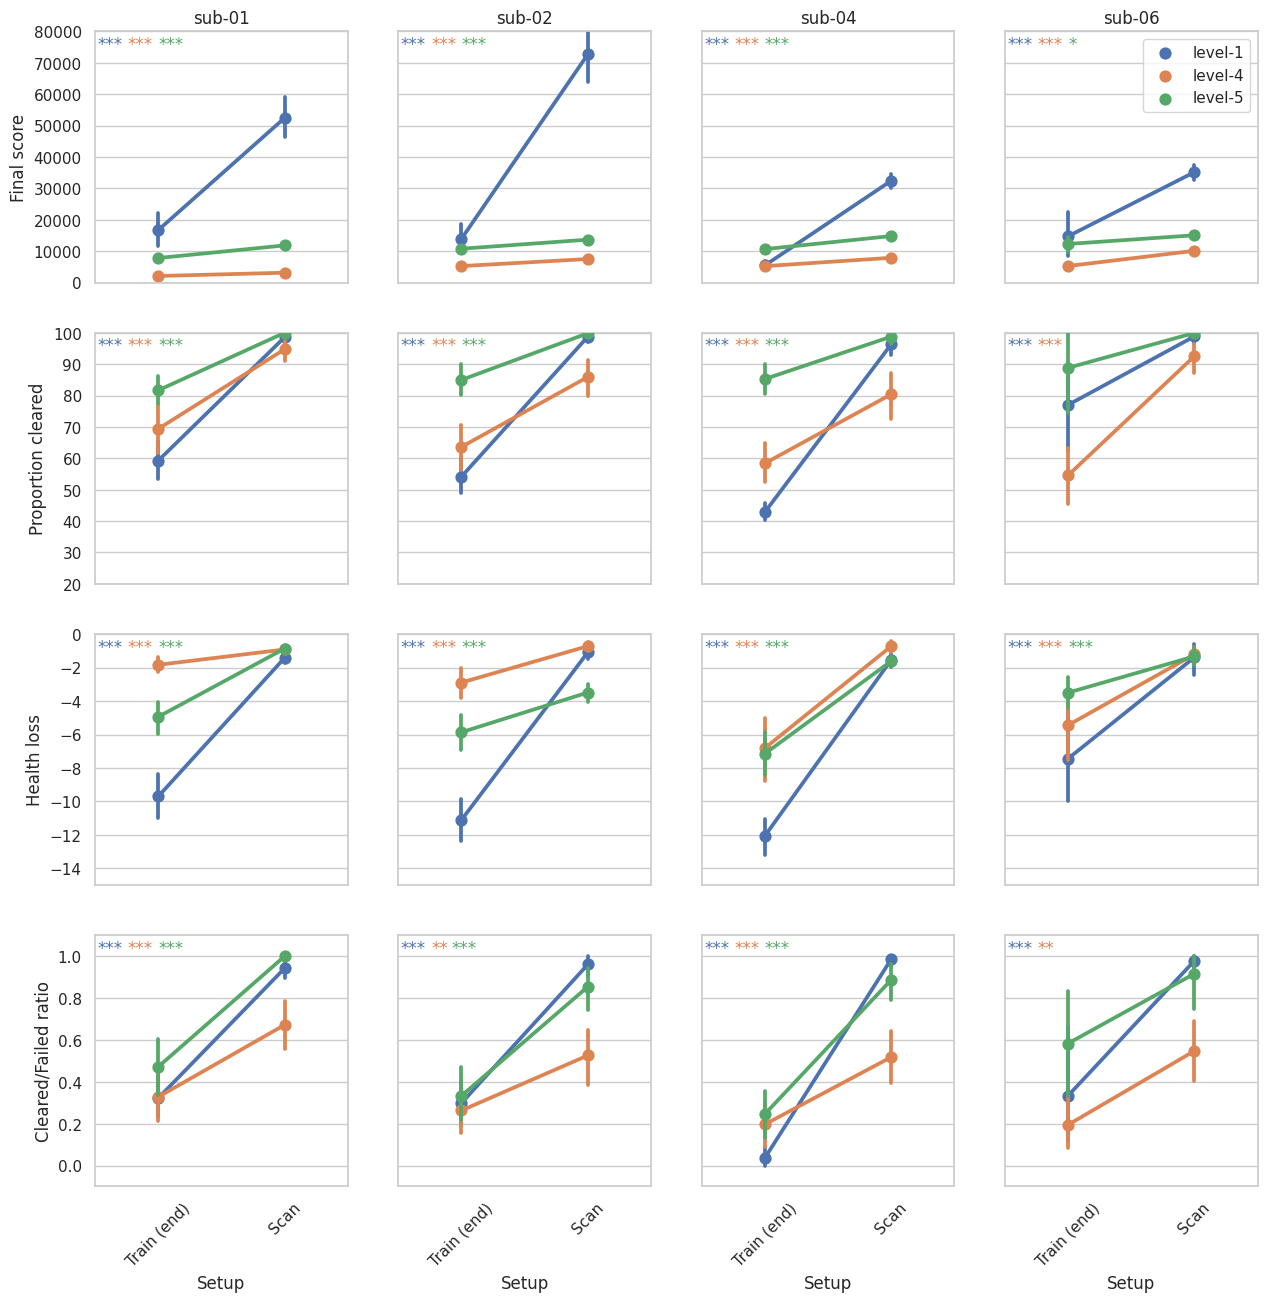

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import statsmodels
sns.set_theme(style="whitegrid")


# Load the example exercise dataset
#df = sns.load_dataset("exercise")
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)
variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']

def annotate_pointplot(text_str, ax):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]
    x, y = 0.01, 0.93  # (0.5, 0.01) means middle in x-axis and very bottom in y-axis
    # Use TextPath to place each segment of the text and color it
    for text, color in zip(text_str, colors):
        ax.text(x, y, text, **{'color':color}, transform=ax.transAxes)
        # Update the x position for next word (depends on length of the current word)
        x += len(text) * 0.04

# Compute stats
pvals_list = []
testID_list = []
for idx_var, var in enumerate(variables):
    for idx_sub, sub in enumerate(np.unique(df['Subject'])):
        data = df[df['Subject']==sub]
        for idx, level in enumerate(np.unique(data['Level'])):
            data_level = data[data['Level']==level]
            # T-test for continuous variables, Fisher exact test for categorical
            if var != 'Cleared/Failed ratio':
                pvalue = stats.ttest_ind(data_level[data_level['Setup split(last N)']=='Train (end)'][var], 
                                        data_level[data_level['Setup split(last N)']=='Scan'][var])[1]
            else:
                minidf = data_level[data_level['Setup split(last N)']!='Train (beginning)']
                table = pd.crosstab(minidf['Cleared/Failed ratio'], minidf['Setup split(last N)'])
                pvalue = stats.fisher_exact(table)[1]
            pvals_list.append(pvalue)
            testID_list.append(f'{var}_{sub}_{level}')

# Compute q values with fdr_bh
reject, qvals_list = statsmodels.stats.multitest.fdrcorrection(pvals_list, alpha=0.05, method='indep', is_sorted=False)
# Create annotation strings
text_str_dict = {}
for idx, testID in enumerate(testID_list):
    subject = testID.split('_')[1]
    variable = testID.split('_')[0]
    if f'{variable}_{subject}' not in text_str_dict.keys():
        text_str_dict[f'{variable}_{subject}'] = [format_pvalue(qvals_list[idx])]
    else:
        text_str_dict[f'{variable}_{subject}'].append(format_pvalue(qvals_list[idx]))

for idx_var, var in enumerate(variables):
    for idx_sub, sub in enumerate(np.unique(df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = [0,20,-15,-0.1]
        vmax = [80000,100,0,1.1]
        sns.pointplot(x="Setup split(last N)", y=var, hue="Level",
                      #capsize=.2, height=6, aspect=.75, point_alpha=0.65, errwidth=0.8, 
                      order=['Train (end)', 'Scan'],#['Train (0-50%)', 'Train (50-100%)', 'Scan'],#['Train (0-1w)', 'Train (1-12w)', 'Train (12w+)', 'Scan'],
                      data=df[df['Subject']==sub], ax=ax)
        text_str = text_str_dict[f'{var}_{sub}']
        annotate_pointplot(text_str, ax)

        # Polish
        ax.set_ylim([vmin[idx_var], vmax[idx_var]])
        plt.legend().remove()
        ax.set_xlabel('Setup') # Force Setup xlabel name
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])
        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        plt.xticks(rotation=45)

In [17]:
pvals_list

[9.439987257857215e-15,
 9.735969939290124e-10,
 4.032588014250144e-24,
 3.587766653007714e-23,
 1.6284425154289185e-06,
 6.684642788390182e-08,
 3.294437776041914e-39,
 7.695408813336987e-09,
 2.7466221449989253e-13,
 2.463199126143554e-08,
 2.0552951923425903e-14,
 0.04665104220421347,
 3.3268590315831404e-25,
 2.994510033643888e-08,
 1.0311392169388025e-11,
 2.8082703928714556e-30,
 1.0373866377133886e-05,
 2.902118036078839e-08,
 1.2840227384991636e-50,
 2.303446737166146e-05,
 1.3035420315499626e-06,
 2.074229126962505e-06,
 4.709281997013854e-11,
 0.11277060550461615,
 8.422955242188396e-25,
 0.000770810801179978,
 2.279754326426893e-12,
 2.12283182398695e-31,
 1.8567723086012592e-05,
 0.00022272738447837151,
 8.490520348377762e-37,
 2.3185356701389056e-09,
 1.8745053517411857e-12,
 1.1818186699260214e-05,
 6.276747968295261e-05,
 0.0008554579372895455,
 1.1885738127442356e-18,
 0.00025971071235374405,
 5.4453812830468895e-11,
 4.566531799694803e-19,
 0.006990669799209111,
 3.879

In [23]:
for idx, ID in enumerate(testID_list):
    print(ID, "­{:.5f}".format(qvals_list[idx]))

Final score_sub-01_level-1 ­0.00000
Final score_sub-01_level-4 ­0.00000
Final score_sub-01_level-5 ­0.00000
Final score_sub-02_level-1 ­0.00000
Final score_sub-02_level-4 ­0.00000
Final score_sub-02_level-5 ­0.00000
Final score_sub-04_level-1 ­0.00000
Final score_sub-04_level-4 ­0.00000
Final score_sub-04_level-5 ­0.00000
Final score_sub-06_level-1 ­0.00000
Final score_sub-06_level-4 ­0.00000
Final score_sub-06_level-5 ­0.04868
Proportion cleared_sub-01_level-1 ­0.00000
Proportion cleared_sub-01_level-4 ­0.00000
Proportion cleared_sub-01_level-5 ­0.00000
Proportion cleared_sub-02_level-1 ­0.00000
Proportion cleared_sub-02_level-4 ­0.00002
Proportion cleared_sub-02_level-5 ­0.00000
Proportion cleared_sub-04_level-1 ­0.00000
Proportion cleared_sub-04_level-4 ­0.00003
Proportion cleared_sub-04_level-5 ­0.00000
Proportion cleared_sub-06_level-1 ­0.00000
Proportion cleared_sub-06_level-4 ­0.00000
Proportion cleared_sub-06_level-5 ­0.11517
Health loss_sub-01_level-1 ­0.00000
Health loss_sub-

## Training progression

In [33]:
# Select only the training data
lcurves_df = df[df['Setup'] != 'Scan']

# Apply a rolling median to smooth the curves
numerical_cols = ['Days of training', 'Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
rolling_df = df[numerical_cols].rolling(window=5).mean()
#lcurves_df[numerical_cols] = rolling_df

In [34]:
# Compute stats
from scipy.stats import spearmanr

def spearman_test(df, var):
    return spearmanr(df[var], df['Days of training'], alternative='greater')

df_dict = {}
for var in variables:
    spearman_series = lcurves_df.groupby(['Subject', 'Level']).apply(spearman_test, var)
    spearman_df = pd.DataFrame()
    spearman_df['Spearman R'] = spearman_series.apply(lambda x: x[0])
    spearman_df['p-value'] = spearman_series.apply(lambda x: x[1])
    df_dict[var] = spearman_df
full_spearman_df = pd.concat(df_dict, axis=1, keys=df_dict.keys())




In [35]:
full_spearman_df

Final score           Proportion cleared                \
                 Spearman R   p-value         Spearman R       p-value   
Subject Level                                                            
sub-01  level-1    0.208268  0.002116           0.214012  1.635258e-03   
        level-4    0.244837  0.004970           0.211794  1.316862e-02   
        level-5    0.157186  0.045984           0.238786  4.919869e-03   
sub-02  level-1   -0.039444  0.737896           0.012067  4.227848e-01   
        level-4    0.208084  0.000180           0.305528  5.543217e-08   
        level-5    0.160009  0.131014           0.086811  2.723468e-01   
sub-04  level-1    0.111375  0.204741           0.205641  6.243991e-02   
        level-4    0.343167  0.000271           0.461300  8.744001e-07   
        level-5    0.271226  0.020637           0.169886  1.032221e-01   
sub-06  level-1    0.183340  0.318404           0.000000  5.000000e-01   
        level-4    0.467288  0.002030           0.316155  3.015738e-02   
        level-5    0.480758  0.002674           0.291688  5.263372e-02   

                Health loss           Cleared/Failed ratio                
                 Spearman R   p-value           Spearman R       p-value  
Subject Level                                                             
sub-01  level-1   -0.338555  0.999999            -0.481153  1.000000e+00  
        level-4   -0.036552  0.647698             0.186567  2.549591e-02  
        level-5    0.273554  0.001483             0.255389  2.829792e-03  
sub-02  level-1    0.091087  0.070346             0.070204  1.282932e-01  
        level-4    0.058069  0.162203             0.027266  3.218989e-01  
        level-5   -0.054355  0.647593             0.279070  2.367573e-02  
sub-04  level-1    0.033549  0.402165             0.058376  3.331134e-01  
        level-4    0.146343  0.075233             0.289674  1.907121e-03  
        level-5    0.421464  0.000547             0.391650  1.294495e-03  
sub-06  level-1   -0.202526  0.699370            -0.100000  6.010142e-01  
        level-4   -0.049909  0.613735            -0.217963  8.992061e-01  
        level-5    0.515408  0.001268             0.760954  2.145030e-07

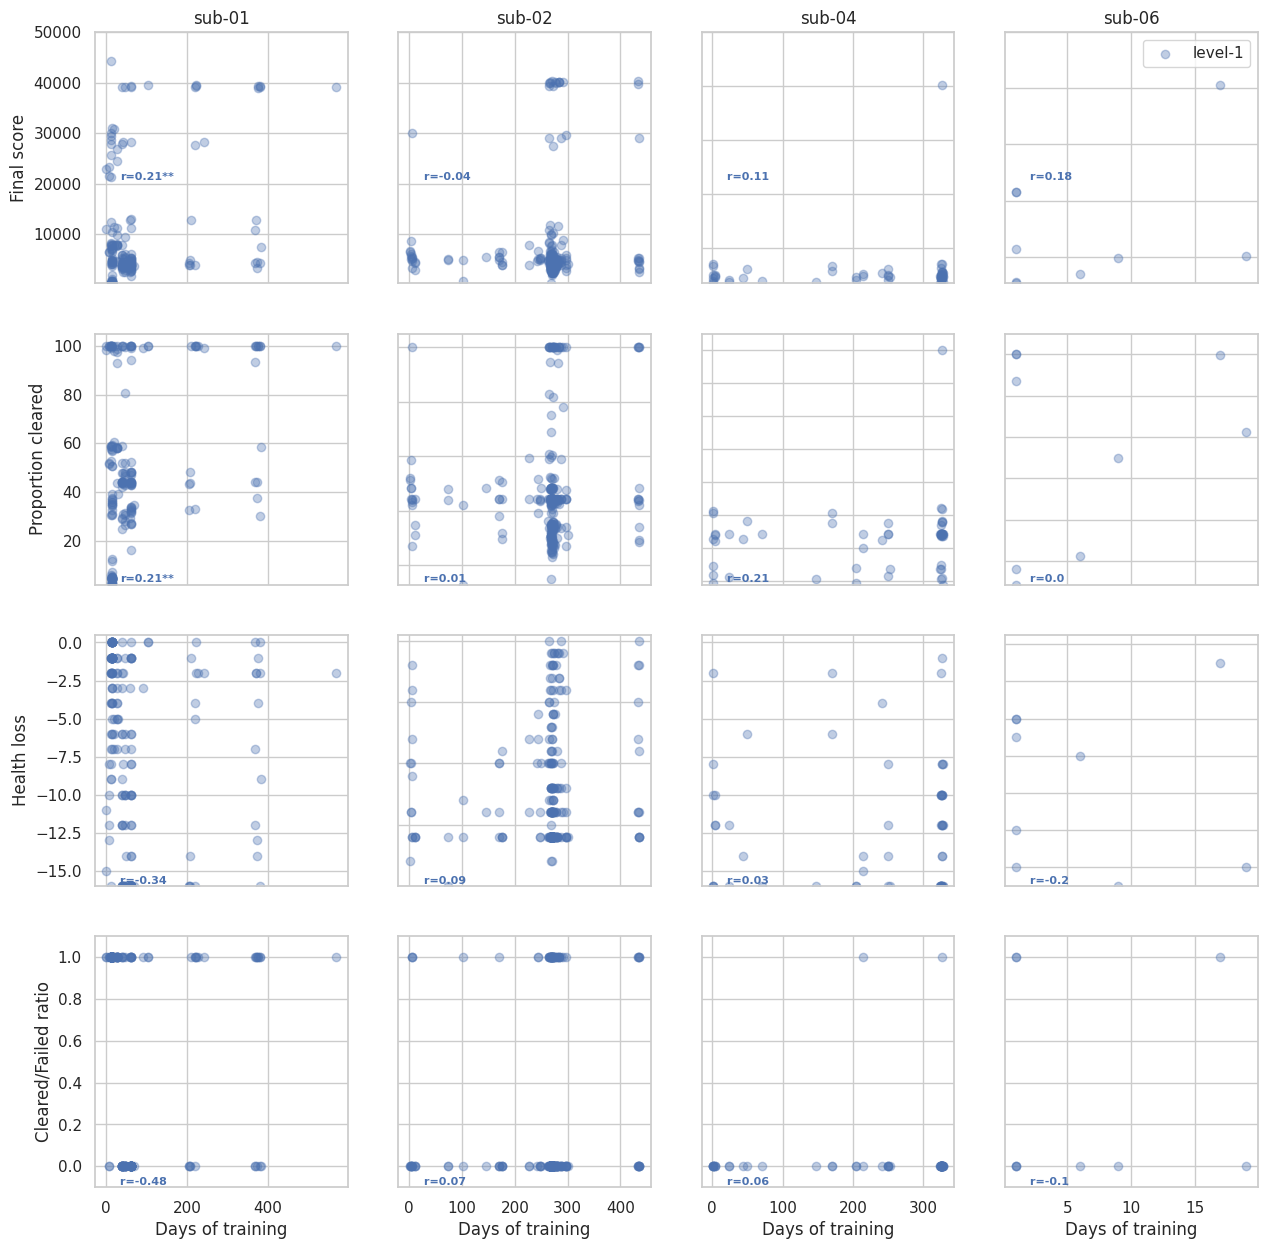

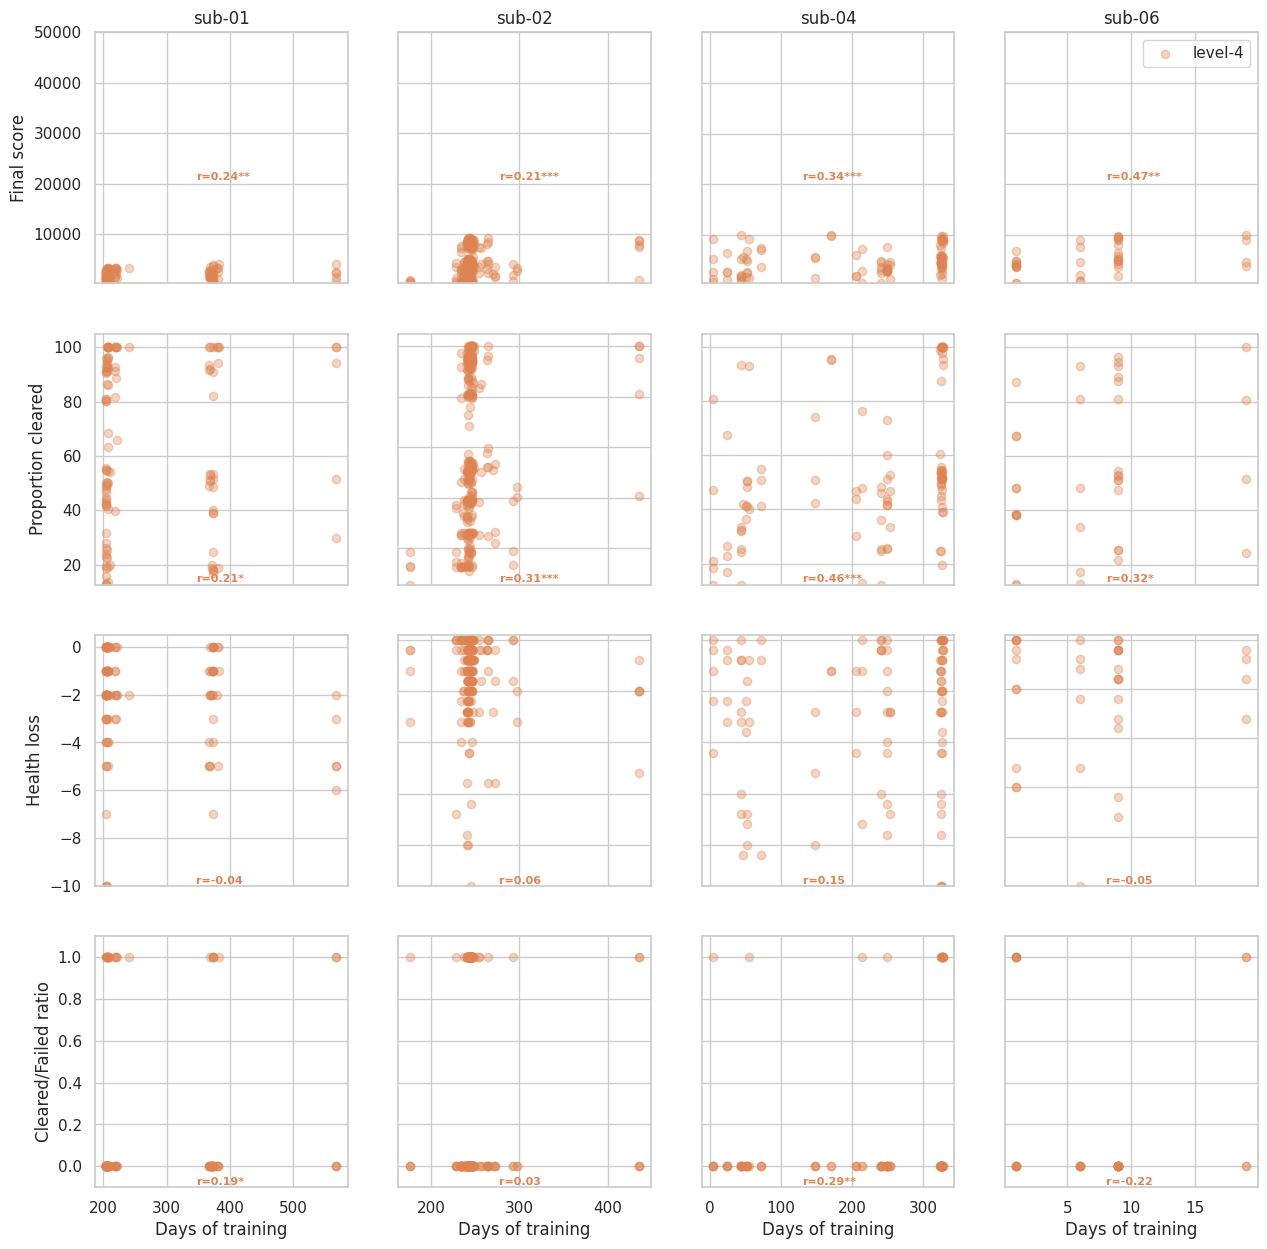

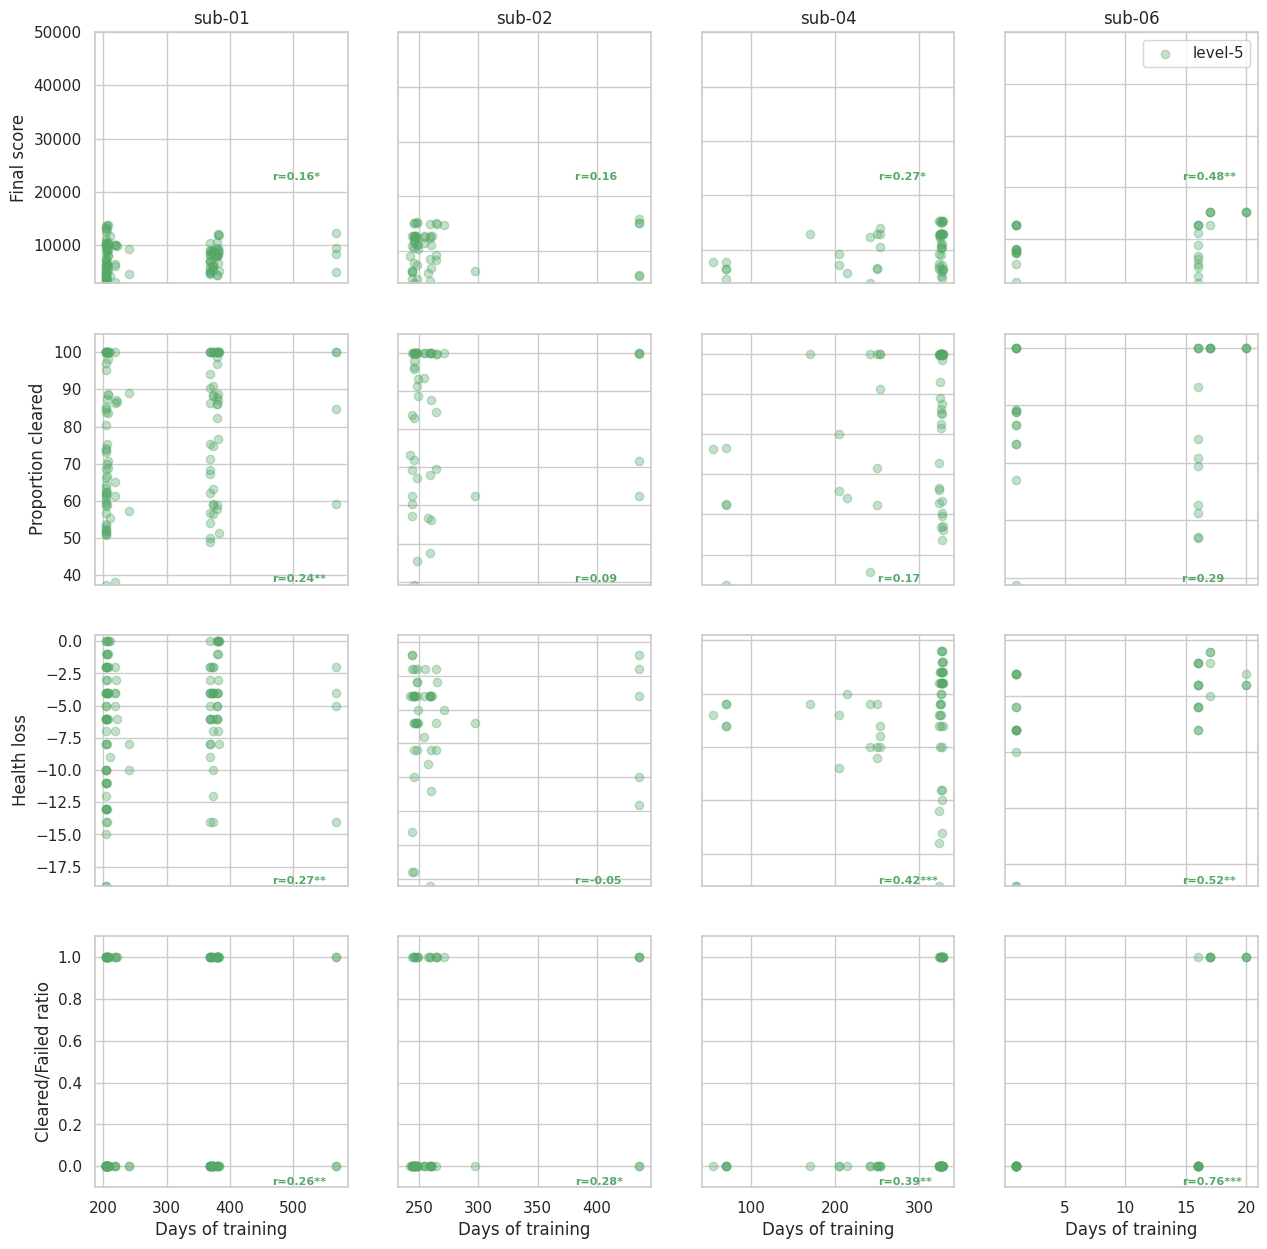

In [36]:


variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
for level_idx, level in enumerate(np.unique(lcurves_df.Level)):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(4,4)
    # get the first three matplotlib default colors
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

    for idx_var, var in enumerate(variables):
        for idx_sub, sub in enumerate(np.unique(lcurves_df['Subject'])):
            filtered_df = lcurves_df[(lcurves_df['Subject']==sub) & (lcurves_df['Level']==level)]
            ax = plt.subplot(gs[idx_var, idx_sub])
            vmin = np.min(filtered_df[var])
            vmax = np.max(filtered_df[var])+5
            fscore_offset=0
            if var == 'Cleared/Failed ratio':
                vmax = 1.1
                vmin = -0.1
            if var == 'Final score':
                vmax = 50000
                fscore_offset = 0.4
            if var == 'Health loss':
                vmax = 0.5
            #sns.scatterplot(x="Days of training", y=var, hue="Level", alpha=0.35,
            #              data=lcurves_df[lcurves_df['Subject']==sub], ax=ax)

            ax.scatter(x="Days of training", y=var, 
                        alpha=0.35, label=level,
                        data=filtered_df, color=colors[level_idx])
            r_val = round(full_spearman_df.loc[(sub, level), (var, 'Spearman R')], 2)
            p_val = round(full_spearman_df.loc[(sub, level), (var, 'p-value')], 4)
            #x, y = get_annotation_pos(filtered_df, var, level_idx)
            ax.text(0.1+(level_idx*0.3), 0.01+fscore_offset, f"r={r_val}{format_pvalue(p_val)}", 
                    transform=ax.transAxes, fontsize=8,
                    color=colors[level_idx], fontweight='bold')        

            # Polish
            ax.set_ylim([vmin, vmax])
            
            plt.legend().remove()
            if idx_var == 0 and idx_sub == 3:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles[:3], labels=labels[:3])
            ax.set_xlabel('Days of training')
            if var == 'Clear/Failed ratio':
                ax.set_ylabel('Cleared/Failed')
            else:
                ax.set_ylabel(var)
            if idx_var == 0:
                plt.title(sub)
            if not idx_var == 3:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            if not idx_sub == 0:
                ax.set_yticklabels([])
                ax.set_ylabel('')

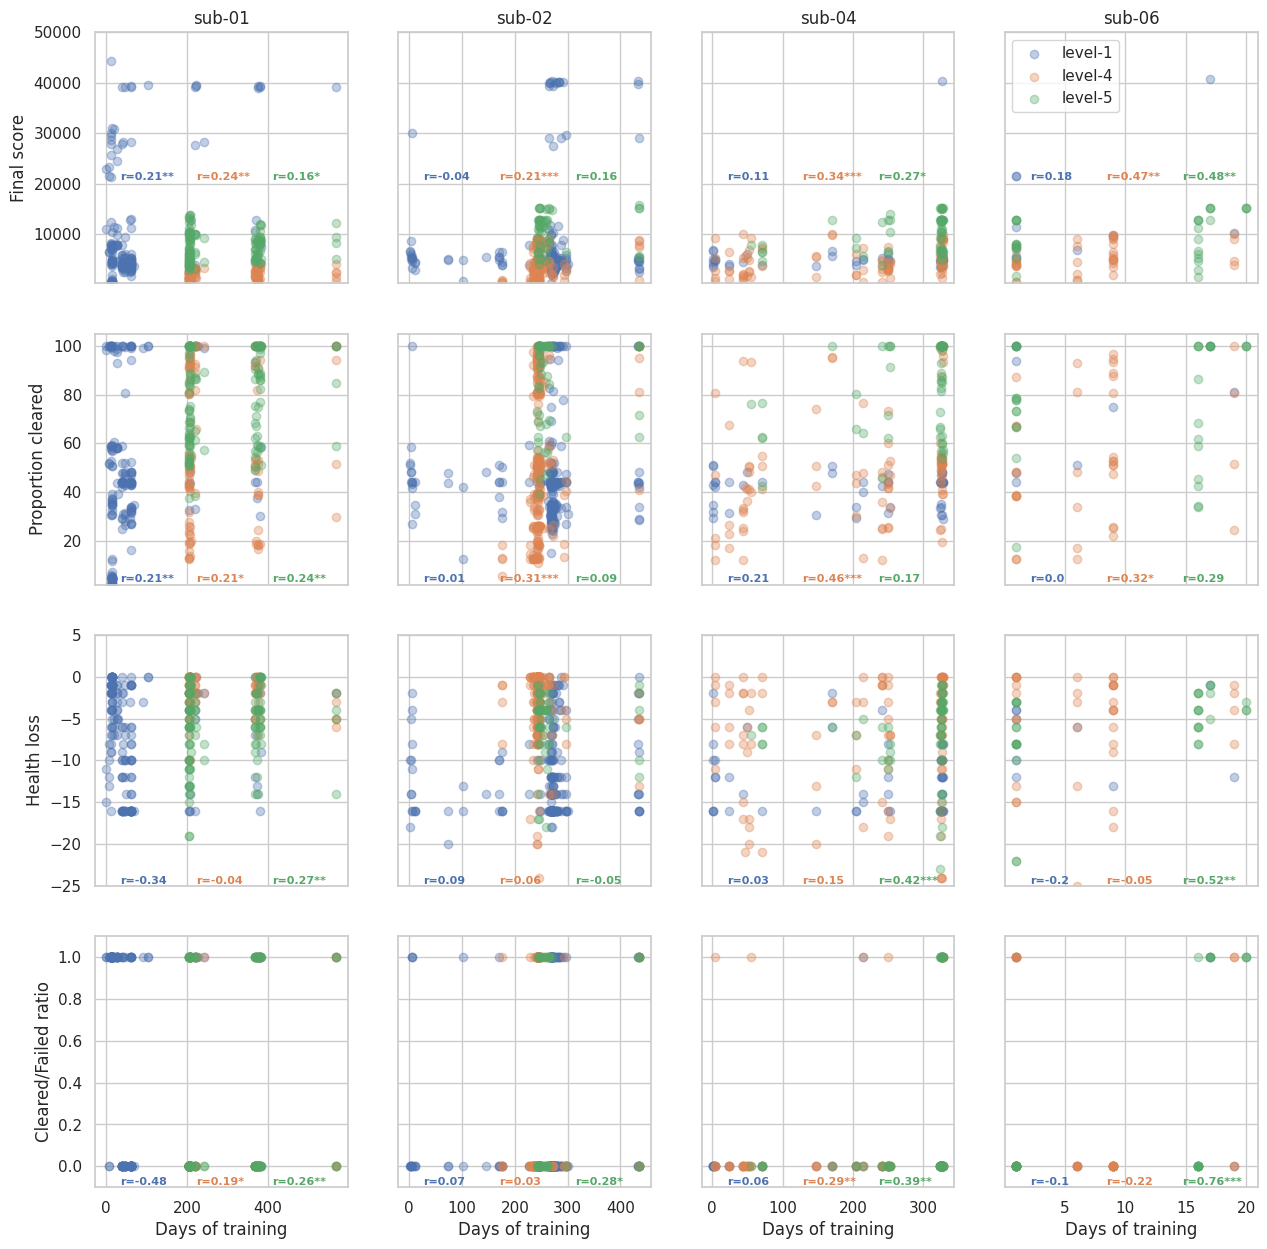

In [34]:
# All together

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)
# get the first three matplotlib default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

variables = ['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
for idx_var, var in enumerate(variables):
    for idx_sub, sub in enumerate(np.unique(lcurves_df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = np.min(lcurves_df[var])
        vmax = np.max(lcurves_df[var])+5
        fscore_offset=0
        if var == 'Cleared/Failed ratio':
            vmax = 1.1
            vmin = -0.1
        if var == 'Final score':
            vmax = 50000
            fscore_offset = 0.4

        for level_idx, level in enumerate(np.unique(lcurves_df.Level)):
            filtered_df = lcurves_df[(lcurves_df['Subject']==sub) & (lcurves_df['Level']==level)]
            ax.scatter(x="Days of training", y=var, 
                       alpha=0.35, label=level,
                       data=filtered_df)
            r_val = round(full_spearman_df.loc[(sub, level), (var, 'Spearman R')], 2)
            p_val = round(full_spearman_df.loc[(sub, level), (var, 'p-value')], 4)
            #x, y = get_annotation_pos(filtered_df, var, level_idx)
            ax.text(0.1+(level_idx*0.3), 0.01+fscore_offset, f"r={r_val}{format_pvalue(p_val)}", 
                    transform=ax.transAxes, fontsize=8,
                    color=colors[level_idx], fontweight='bold')        

        # Polish
        ax.set_ylim([vmin, vmax])
        
        plt.legend().remove()
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])
        ax.set_xlabel('Days of training')
        ax.set_ylabel(var)
        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')

# Deprecated

In [171]:
# Balance the dataframe via sampling

def sample_df(df):
    df_sampled = []
    for sub in np.unique(df['Subject']):
        subject_df = df[df['Subject']==sub]
        for level in np.unique(subject_df['Level']):
            level_df = subject_df[subject_df['Level']==level]
            min_count = level_df['Setup split(idx)'].value_counts().min()
            for setup in np.unique(level_df['Setup split(idx)']):
                setup_df = level_df[level_df['Setup split(idx)']==setup]
                df_sampled.append(setup_df.sample(n=min_count, random_state=1))
    df_sampled = pd.concat(df_sampled)
    return df_sampled

df_sampled = sample_df(df)
df_sampled.groupby(['Subject', 'Level', 'Setup split(idx)']).describe()


Health loss                             \
                                       count       mean       std   min   
Subject Level   Setup split(idx)                                          
sub-01  level-1 Scan                    87.0  -1.425287  1.394609  -6.0   
                Train (0-50%)           87.0  -3.425287  4.039434 -16.0   
                Train (50-100%)         87.0  -9.655172  6.124346 -16.0   
        level-4 Scan                    55.0  -0.981818  1.009050  -3.0   
                Train (0-50%)           55.0  -2.054545  2.519687 -10.0   
                Train (50-100%)         55.0  -1.909091  1.838606  -7.0   
        level-5 Scan                    53.0  -0.867925  0.855699  -3.0   
                Train (0-50%)           53.0  -6.283019  4.817346 -19.0   
                Train (50-100%)         53.0  -4.981132  3.505438 -14.0   
sub-02  level-1 Scan                    77.0  -1.090909  1.623688  -7.0   
                Train (0-50%)           77.0 -12.883117  4.167462 -20.0   
                Train (50-100%)         77.0 -11.259740  5.685630 -16.0   
        level-4 Scan                    57.0  -0.719298  1.114104  -5.0   
                Train (0-50%)           57.0  -2.877193  4.049119 -20.0   
                Train (50-100%)         57.0  -1.789474  2.320228 -10.0   
        level-5 Scan                    25.0  -3.120000  1.964688 -10.0   
                Train (0-50%)           25.0  -5.760000  4.456082 -17.0   
                Train (50-100%)         25.0  -6.120000  3.734077 -18.0   
sub-04  level-1 Scan                    28.0  -1.071429  1.184110  -4.0   
                Train (0-50%)           28.0 -12.250000  4.647779 -16.0   
                Train (50-100%)         28.0 -11.964286  4.131919 -16.0   
        level-4 Scan                    46.0  -0.760870  1.232608  -6.0   
                Train (0-50%)           46.0  -7.021739  6.855619 -21.0   
                Train (50-100%)         46.0  -7.195652  7.060436 -24.0   
        level-5 Scan                    27.0  -1.777778  1.423250  -6.0   
                Train (0-50%)           27.0  -8.925926  4.322801 -23.0   
                Train (50-100%)         27.0  -5.592593  4.692541 -18.0   
sub-06  level-1 Scan                    14.0  -3.071429  5.341626 -16.0   
                Train (0-50%)           14.0  -6.214286  4.060666 -16.0   
                Train (50-100%)         14.0  -8.357143  4.325366 -16.0   
        level-4 Scan                    27.0  -0.777778  1.502135  -7.0   
                Train (0-50%)           27.0  -4.333333  5.656854 -17.0   
                Train (50-100%)         27.0  -5.370370  6.190241 -25.0   
        level-5 Scan                    12.0  -1.333333  0.887625  -3.0   
                Train (0-50%)           12.0  -7.416667  5.035480 -22.0   
                Train (50-100%)         12.0  -3.833333  2.037527  -8.0   

                                                          Final score  \
                                    25%   50%    75%  max       count   
Subject Level   Setup split(idx)                                        
sub-01  level-1 Scan              -2.00  -1.0   0.00  0.0        87.0   
                Train (0-50%)     -5.00  -2.0  -1.00  0.0        87.0   
                Train (50-100%)  -16.00 -10.0  -3.00  0.0        87.0   
        level-4 Scan              -2.00  -1.0   0.00  0.0        55.0   
                Train (0-50%)     -3.00  -1.0   0.00  0.0        55.0   
                Train (50-100%)   -3.00  -2.0   0.00  0.0        55.0   
        level-5 Scan              -1.00  -1.0   0.00  0.0        53.0   
                Train (0-50%)    -10.00  -5.0  -2.00  0.0        53.0   
                Train (50-100%)   -6.00  -4.0  -3.00  0.0        53.0   
sub-02  level-1 Scan              -2.00   0.0   0.00  0.0        77.0   
                Train (0-50%)    -16.00 -15.0 -10.00  0.0        77.0   
                Train (50-100%)  -16.00 -14.0  -6.00  0.0        77.0   
        leve